Datasets:


1.   Shots Fired
  *   7553 rows and 5 columns in this dataset
  *   3 rows with at least one empty value
2.   Shootings - Datasets - Analyze Boston
  *   1798 rows and 9 columns in this dataset
  *   46 rows with at least one empty value
3.   City Council Dataset
  * 9 rows and 37 columns in this dataset


Assumption made:


1.   District 4 is made up of Boston Police Districts B2, B3, C11 and E5



In [ ]:
!pip install pyshp
!pip install requests # For API call
!pip install geopandas
!pip install geoplot
!pip install mapclassify

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import shapefile as shp
import requests as rq
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import os
import sys
import itertools
import warnings
import geopandas as gpd
import geoplot as gplt
import geoplot.crs as gcrs
import mapclassify as mc

warnings.filterwarnings("ignore")

### Number of Gun Violence Incidents in Each District for Each Year


In [ ]:
#load data
shots_fired_URL = "https://data.boston.gov/api/3/action/datastore_search?resource_id=c1e4e6ac-8a84-4b48-8a23-7b2645a32ede&limit=7553"
shootings_URL = "https://data.boston.gov/api/3/action/datastore_search?resource_id=73c7e069-701f-4910-986d-b950f46c91a1&limit=10000"
shot_nv = pd.DataFrame((rq.get(url = shots_fired_URL)).json().get('result').get('records'))
shot_v = pd.DataFrame((rq.get(url = shootings_URL)).json().get('result').get('records'))
print(shot_nv.keys())
print(shot_nv.shape)
print("There are " +  str(shot_nv.isna().any(axis=1).sum()) + " rows with at least one empty value in shots fired dataset")
print("\n")
print(shot_v.keys())
print(shot_v.shape)
print("There are " +  str(shot_v.isna().any(axis=1).sum()) + " rows with at least one empty value in shootings dataset")

Index(['incident_date', 'ballistics_evidence', '_id', 'district',
       'incident_num'],
      dtype='object')
(7553, 5)
There are 3 rows with at least one empty value in shots fired dataset


Index(['shooting_type_v2', 'victim_ethnicity_NIBRS', 'district',
       'incident_num', 'victim_race', 'multi_victim', 'victim_gender', '_id',
       'shooting_date'],
      dtype='object')
(1798, 9)
There are 46 rows with at least one empty value in shootings dataset


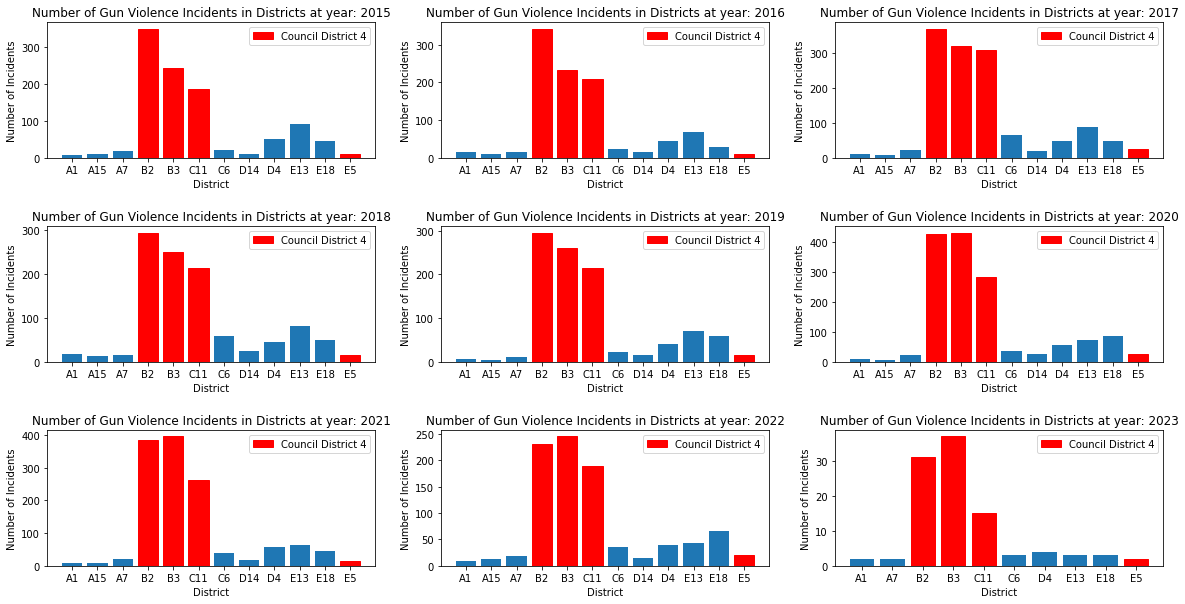

In [ ]:
#execute order 66
# only get district column
shot_nv = shot_nv[['district', 'incident_date']]
shot_v = shot_v.rename(columns={'shooting_date': 'incident_date'})
shot_v = shot_v[['district', 'incident_date']]
# get year
shot_nv['incident_date'] = shot_nv['incident_date'].str[:4]
shot_v['incident_date'] = shot_v['incident_date'].str[:4]
#reset stuff to combine datasets
shot_nv.reset_index(drop=True, inplace=True)
shot_v.reset_index(drop=True, inplace=True)
# combine
frames = [shot_nv, shot_v]
result = pd.concat(frames)
# count duplicates to get number of incidents 
result = result.pivot_table(index = ['district', 'incident_date'], aggfunc ='size').reset_index()
result.rename(columns={0: 'num_inc'}, inplace=True)
# loop through number of years and get graph
years = ['2015', '2016', '2017', '2018', '2019', '2020', '2021', '2022', '2023']
district_4 = ['B2', 'B3', 'C11', 'E5']
plt.figure(figsize=(20, 10))
plt.subplots_adjust(hspace=0.5)
i = 0
for year in years: 
    results = result.loc[result['incident_date'] == year]
    ax = plt.subplot(3, 3, i + 1)
    bar = plt.bar(results['district'].values, results['num_inc'].values)
    # color council district 4
    for district in district_4:
        index = np.where(results['district'].values == district)
        bar[index[0][0]].set_color('r')
    ax.set_title('Number of Gun Violence Incidents in Districts at year: '+str(year))
    ax.set_xlabel('District')
    ax.set_ylabel('Number of Incidents')
    red_patch = mpatches.Patch(color='red', label='Council District 4')
    ax.legend(bbox_to_anchor=(1, 1), handles=[red_patch])
    i += 1
plt.show()

These bar charts show the number of gun violence incidents per year for each police district. Colored in red is the police districts that are inside the council city district 4.

Key Findings from this graph:

* All the districts associated with the council city district 4 have the highest rate of gun violence compared to the rest of the districts
* For every year the trend of gun violence for each police district is fairly unchanging. This showcases that gun violence is not inherently dependent on the timeframe

### Ratio of Gun Violence Per Year (District 4 vs Rest of Boston)

In [ ]:
URL = "https://data.boston.gov/datastore/odata3.0/73c7e069-701f-4910-986d-b950f46c91a1?$top=10000&$format=json"

r = rq.get(url = URL)
data = r.json()
data = data.get('value')
df = pd.DataFrame(data)

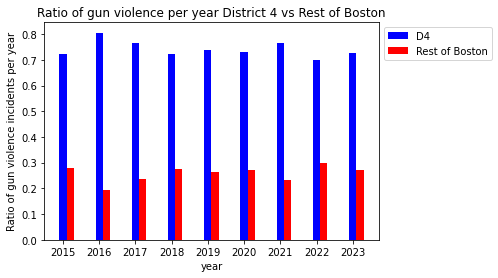

In [ ]:
def get_year(row):
  return row.split("-")[0]

def get_city_council_district(row):
  if row['index'] % 2 == 0:
    return "District 4"
  else:
    return "Rest of Boston"

def get_data_by_city_council_district(row):
  if row['district'] in district_4:
    val = list(df3[(df3['year'] == row['year']) & (df3['location'] == 'District 4')]['number of shootings per location'].astype(int))
    val[0] += row['number of shootings']
    index = list(df3[(df3['year'] == row['year']) & (df3['location'] == 'District 4')]['index'])[0]
    df3.loc[index,'number of shootings per location'] = val[0]
  else:
    val = list( df3[(df3['year'] == row['year']) & (df3['location'] == 'Rest of Boston')]['number of shootings per location'].astype(int))
    val[0] += row['number of shootings']
    index = list(df3[(df3['year'] == row['year']) & (df3['location'] == 'Rest of Boston')]['index'])[0]
    df3.loc[index,'number of shootings per location'] = val[0]

district_4 = ['B2', 'B3', 'C11', 'E5']
df1 = df.copy()
df1['year'] = df1['shooting_date'].apply(get_year)
data_per_year = df1.groupby('year').size()
#added reset index to turn the series back to a dataframe
data_district_per_year = df1.groupby(['year', 'district']).size().reset_index()

df2 = pd.DataFrame(data_district_per_year).reset_index()
df2.rename(columns={0: 'number of shootings'}, inplace=True)
years = df2['year'].unique()

df3 = pd.DataFrame(years)
df3.rename(columns={0: 'year'}, inplace=True)
# Repeat the years twice, so have 2 rows with the same year, one for District 4, 
# another for Rest of Boston
df3 = df3.loc[df3.index.repeat(2)].reset_index(drop=True)
# Add index to the dataset, to be used in assigning the location (District 4 and Rest of Boston)
df3['index'] = df3.index
# Rearrange the order of columns
df3 = df3[['index', 'year']]
# Assign District 4 or Rest of Boston to location column
df3['location'] = df3.apply(get_city_council_district, axis=1)
# Initialize the number of shootings per year to 0
df3['number of shootings per location'] = 0
# Assign the total number of shootings per year
df3['number of shootings per year'] = data_per_year.loc[data_per_year.index.repeat(2)].reset_index(drop=True)
# Get the number of shootings for District 4 and Rest of Boston per year
df2.apply(get_data_by_city_council_district, axis=1)
df3['rate of gun violence per year'] = df3['number of shootings per location']/df3['number of shootings per year']

# plot data
X_axis = np.arange(len(years))
ax = plt.subplot(111)
ax.bar(X_axis, df3[(df3['location'] == 'District 4')]['rate of gun violence per year'], width=0.2, color='b', align='center', label='D4')
ax.bar(X_axis+0.2, df3[(df3['location'] == 'Rest of Boston')]['rate of gun violence per year'], width=0.2, color='r', align='center', label='Rest of Boston')
ax.set_xticks(X_axis)
ax.set_xticklabels(list(years))
ax.set_xlabel('year')
ax.set_ylabel('Ratio of gun violence incidents per year')
ax.set_title('Ratio of gun violence per year District 4 vs Rest of Boston')
ax.legend(bbox_to_anchor=(1, 1))
plt.show()

The bar chart below shows the ratio of gun violence incidents per year for district 4 versus the rest of Boston. Colored in blue are the police districts that form District 4.

Key Findings from this graph:


1.   District 4 has the highest ratio of gun violence every single year from 2015 to 2023.
2.   The disparity in the ratio of gun violence between District 4 and the rest of Boston ranges from slightly more than twice to slightly more than 4 times.
3.   The highest ratio of gun violence occurred in 2016, with 80% of gun violence in that year occurring in District 4.
4.   In 2023 alone, 70% of gun violence thus far occurred in District 4.





## Number of Incidents by District and Race


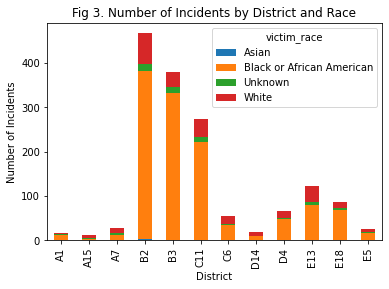

In [ ]:
# Group the data and count the number of incidents per district and race
district_race_grouped = df.groupby(['district', 'victim_race'])['incident_num'].nunique().reset_index()

# Pivot the data to create a table of district vs victim race
pivoted_district_race_grouped = district_race_grouped.pivot(index='district', columns='victim_race', values='incident_num')

# Replace NaN values with 0
pivoted_district_race_grouped.fillna(0, inplace=True)

# Plot the stacked bar chart
pivoted_district_race_grouped.plot(kind='bar', stacked=True)

# Add labels and title
plt.xlabel('District')
plt.ylabel('Number of Incidents')
plt.title('Fig 3. Number of Incidents by District and Race')
plt.show()

This stacked bar chart shows the number of incidents per district and per victim race. Here, each district is represented by a different color in the chart and is divided into segments that represent the number of incidents for each victim race. 

Key Findings from this graph:
1. Black or African American victims are disproportionately affected by shooting incidents, with significantly higher numbers compared to other races.
2. Unknown ethnicity victims are present in relatively high numbers, indicating a need for improved reporting and data collection methods.
3. Incidents involving Asian victims is almost negligible.

## Percentage of Shooting Incidents by Victim Race

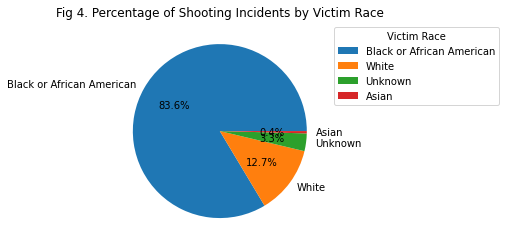

In [ ]:
# Select the subset of the data for the selected districts
selected_districts = ['D4', 'C11', 'B3', 'B2', 'E5']
selected_df = df[df['district'].isin(selected_districts)]

# Count the number of incidents for each victim race in the selected subset
race_counts = selected_df['victim_race'].value_counts()

# Plot the race counts as a pie chart with percentage labels
race_counts.plot(kind='pie', autopct='%1.1f%%', ylabel = "")
# print(race_counts)

plt.legend(title="Victim Race", loc="center left", bbox_to_anchor=(1, 0.8))
plt.title("Fig 4. Percentage of Shooting Incidents by Victim Race")
plt.show()

In the D4 district, the majority of shooting incidents involve Black or African American victims, with a total of 1172 incidents. White victims come in second, with a much smaller number of incidents (178), followed by Unknown (46) and Asian victims (6).

Key Findings from this graph:

1. This data suggests that Black or African American residents in the D4 district are disproportionately affected by shooting incidents. Further analysis and investigation are needed to understand the underlying reasons for this disparity and to develop effective strategies for reducing gun violence in the area.

# District wise intensity of gun violence w.r.t incidents count

In [ ]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


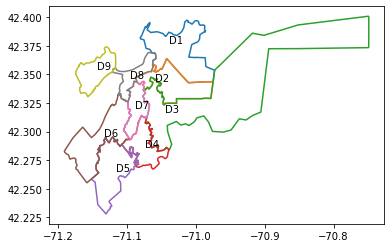

In [ ]:
sf = shp.Reader("/gdrive/My Drive/CS506-DS/data/City_Council_Districts_-_Effective_for_the_2023_Municipal_Election.shp")
fields = [x[0] for x in sf.fields][1:]
records = [list(i) for i in sf.records()]
shps = [s.points for s in sf.shapes()]
plt.figure()

df = pd.DataFrame(columns=fields, data=records)
df = df.assign(coords=shps)
i=0
for shape in sf.shapeRecords():
    x = [i[0] for i in shape.shape.points[:]]
    y = [i[1] for i in shape.shape.points[:]]
    plt.plot(x,y)
    x0 = np.mean(x)
    y0 = np.mean(y)
    plt.text(x0, y0, records[i][2], fontsize=10)
    i+=1
plt.show()


This plot is for sanity checking the city council dataset shapefile to ensure we have bounded shapes, with distinct boundaries and with the appropriate labels.

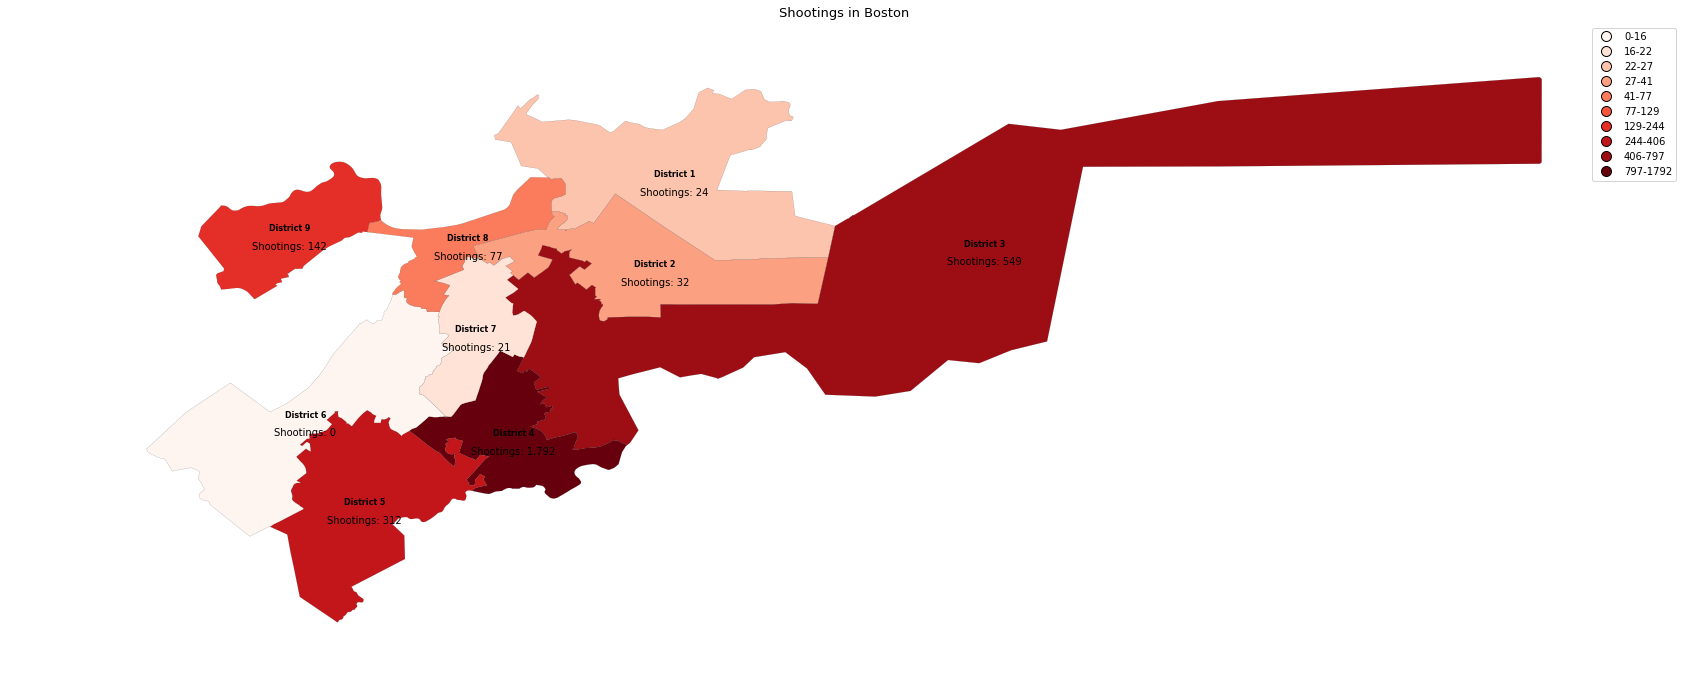

In [ ]:
shp=gpd.read_file("/gdrive/My Drive/CS506-DS/data/City_Council_Districts_-_Effective_for_the_2023_Municipal_Election.shp")
df=pd.read_csv("/gdrive/My Drive/CS506-DS/data/shootings.csv")
dist_count=df.groupby("district").size().reset_index(name='counts')
dist_data = [[row['district'],row['counts']] for index, row in dist_count.iterrows()]
mappings= {
  "A1": 2, "A7": 3, "A7": 1, "A15": 1,
  "B2": 7, "B3": 4, "C11": 3, "C11": 4,
  "C6": 2, "C6": 3, "D14": 9, "D4": 8,
  "E13": 6, "E13": 7, "E18": 5, "E5": 6, 
  "B2": 4, "E5": 4
}
shp["SHOOTING_RATE"]=0
for i in range(len(dist_data)):
  val = shp.loc[shp["DISTRICT"] == mappings[dist_data[i][0]]]["SHOOTING_RATE"] + dist_data[mappings[dist_data[i][0]]][1]
  shp.loc[shp["DISTRICT"] == mappings[dist_data[i][0]],"SHOOTING_RATE"]=val

fig, ax = plt.subplots(1, 1, figsize=(30, 15))
scheme = mc.Quantiles(shp['SHOOTING_RATE'], k=10)
shp['coords'] = shp['geometry'].apply(lambda x: x.centroid.coords[:])
shp['coords'] = [coords[0] for coords in shp['coords']]

gplt.choropleth(shp, hue='SHOOTING_RATE', linewidth=.1,
    scheme=scheme,
    cmap='Reds',
    legend=True,
    edgecolor='black',
    ax=ax,
    legend_labels=[
        '0-16', '16-22', '22-27','27-41', '41-77', '77-129',
        '129-244', '244-406','406-797', '797-1792'
    ]
);

for _, row in shp.iterrows():

  hue = round(row['SHOOTING_RATE'],2)
  plt.text(s=row['LONGNAME'], x = row['coords'][0], y = row['coords'][1],
           horizontalalignment='center', fontdict = {'weight': 'bold', 'size': 8})
  plt.text(s='Shootings: ' + f'{hue:,}', x=row['coords'][0],y = row['coords'][1] - 0.006, 
           horizontalalignment='center', fontdict = {'size': 10})

ax.set_title('Shootings in Boston', fontsize=13);

This map plot shows us the district wise gun violence intensity with the help of color gradients. Here, every district is marked with a color based on the count of gun violence incidents which occured in that district compared to other districts.

Key findings from this map plot:

1. This plot helps us understand the importance of this project as it demonstrates the stark difference in the intensity of gun violence incidents in District 4 versus the rest of Boston.
2. In the D4 district, we see an increase of more that twice the number of incidents compared to the second most affected district (District 3).